In [5]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Definir rutas
model_path = "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/Team_Challenge_Pipelines/src/models/classification_pipeline_LightGBM.joblib"
test_data_path = "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/Team_Challenge_Pipelines/src/data/Test.csv"

# Cargar el modelo preentrenado
print("Cargando el modelo...")
best_model = joblib.load(model_path)
print("Modelo cargado exitosamente.")

# Cargar el conjunto de prueba
df_test = pd.read_csv(test_data_path)
print("Datos de prueba cargados exitosamente.")

# ========================
# 1. Evaluación del Mejor Modelo sobre Datos de Test
# ========================

# Preparar datos de test
X_test = df_test.drop(columns=['ID', 'Segmentation'], errors='ignore')
y_test = df_test["Segmentation"]

# Codificar etiqueta de test si es necesario
if y_test.dtype == object:
    le_test = LabelEncoder()
    y_test = le_test.fit_transform(y_test)

# Preprocesado integrado: se aplican todas las transformaciones que se ajustaron en entrenamiento
X_test_processed = best_model.named_steps['preprocessor'].transform(X_test)

# Realizar predicciones
y_pred = best_model.named_steps['classifier'].predict(X_test_processed)
y_pred_proba = best_model.named_steps['classifier'].predict_proba(X_test_processed)

Cargando el modelo...
Modelo cargado exitosamente.
Datos de prueba cargados exitosamente.


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Accuracy en test: 0.3312

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.28      0.30       846
           1       0.24      0.19      0.21       550
           2       0.26      0.34      0.30       472
           3       0.42      0.49      0.45       759

    accuracy                           0.33      2627
   macro avg       0.31      0.32      0.32      2627
weighted avg       0.33      0.33      0.33      2627



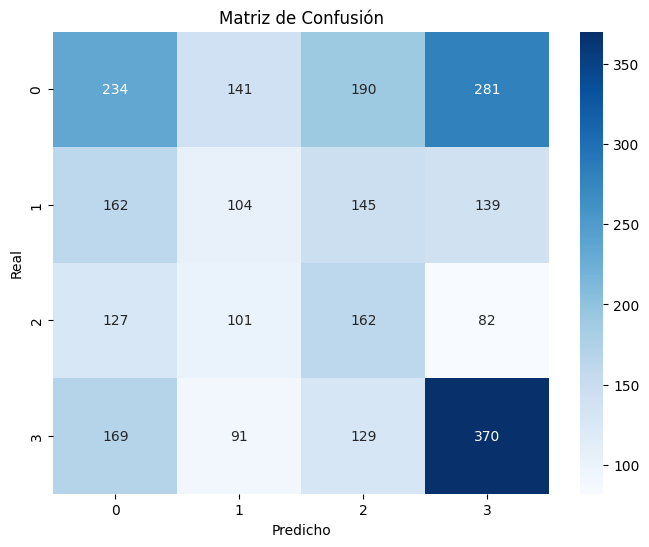

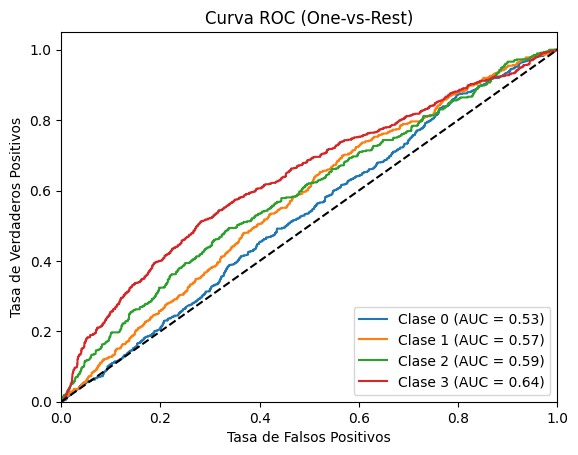

In [6]:
# ========================
# 2. Métricas de Evaluación
# ========================

# Accuracy y Classification Report
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy en test: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Curva ROC (usando One-vs-Rest para clasificación multiclase)
classes = np.unique(y_test)
n_classes = len(classes)
y_test_binarized = label_binarize(y_test, classes=classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f'Clase {i} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

# Análisis de Resultados del Modelo LightGBM

## 1 Evaluación General
- **Accuracy en test: 0.3312**  
  → El modelo predice correctamente el 33.12% de las observaciones en el conjunto de test, lo que es **bajo** si las clases están balanceadas.  
  → Para un modelo de clasificación multiclase, este valor puede ser preocupante si el baseline (p. ej. elegir la clase más común) obtiene una precisión similar.

## 2 Classification Report

- **Clase 3 tiene el mejor desempeño** con un **F1-Score de 0.45**, mientras que la Clase 1 es la más baja con **F1-Score de 0.21**.
- **Recall bajo en casi todas las clases** → El modelo está fallando en detectar correctamente todas las instancias de cada clase.
- **Precision y Recall desbalanceados** en algunas clases → Puede indicar que el modelo está sesgado hacia ciertas clases.

## 3 Matriz de Confusión
- Hay una gran cantidad de errores de clasificación en todas las clases.
- **Clase 3 tiene la mayor cantidad de predicciones correctas (370 aciertos).**
- **Mucha confusión entre las clases 0 y 3** → Se observa que muchas instancias de la clase 0 están clasificadas erróneamente como 3 (281 veces).
- La **Clase 1 tiene un desempeño particularmente malo**, con muchas predicciones incorrectas en todas las demás clases.

## 4 Curva ROC y AUC por Clase

- **Clase 0 → AUC = 0.53**
- **Clase 1 → AUC = 0.57**
- **Clase 2 → AUC = 0.59**
- **Clase 3 → AUC = 0.64**

### Interpretación
- Un AUC cercano a **0.50** indica que el modelo se comporta casi como un **clasificador aleatorio**.  
- **La mejor clase es la 3 con un AUC de 0.64**, pero sigue siendo un valor bajo.  
- **Las demás clases están apenas por encima de 0.50**, lo que sugiere que el modelo **tiene poca capacidad de discriminación**.

---

## Posibles Problemas
1. **Modelo subajustado (underfitting)**  
   → Puede indicar que el modelo no está capturando bien los patrones en los datos.  
   → Podría mejorarse con un **modelo más complejo** o **ajuste de hiperparámetros**.  

2. **Datos desbalanceados**  
   → Si algunas clases tienen muchas más observaciones que otras, el modelo podría estar favoreciendo la clase mayoritaria.  
   → **Solución:** Técnica de oversampling (SMOTE) o undersampling.  

3. **Problemas en las características (features)**  
   → Es posible que las variables utilizadas no sean lo suficientemente discriminativas.  
   → **Solución:** Revisar la importancia de las características y realizar Feature Engineering.  

---

##  Conclusión
El modelo tiene un desempeño **por debajo de lo esperado**, con una precisión baja y una capacidad de discriminación muy limitada. 
Se debería **revisar los datos, probar otras arquitecturas y optimizar el modelo** para mejorar los resultados. 
